# Place Cells 

This notebook analyses place cell activiy.

Goal: find cells that encode current location.

Approach: for this analysis, the the track is spatially binned in order to examine patterns of neural firing across bin locations, to see if individual neurons encode information about specific locations.

In [1]:
%config Completer.use_jedi = False

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import zscore

from convnwb.io import load_nwbfile,make_session_name

from spiketools.spatial.occupancy import (compute_occupancy, compute_trial_occupancy,compute_bin_edges,
                                          compute_bin_counts_pos, normalize_bin_counts)
from spiketools.spatial.information import compute_spatial_information
from spiketools.spatial.place import compute_place_bins, compute_trial_place_bins
from spiketools.spatial.utils import compute_pos_ranges, get_position_xy
from spiketools.stats.shuffle import shuffle_spikes
from spiketools.stats.permutations import compute_surrogate_stats
from spiketools.plts.utils import make_axes, make_grid, get_grid_subplot, save_figure
from spiketools.plts.trials import plot_rasters
from spiketools.plts.spatial import plot_heatmap, plot_positions, plot_position_by_time,create_heatmap_title
from spiketools.plts.annotate import add_vlines, add_hlines,color_pvalue
from spiketools.plts.data import plot_bar, plot_hist, plot_text
from spiketools.plts.style import drop_spines
from spiketools.plts.stats import plot_surrogates

from spiketools.utils.extract import (get_range, get_values_by_time_range,
                                      get_values_by_times, threshold_spikes_by_values)
from spiketools.utils.epoch import epoch_spikes_by_range
from spiketools.utils.data import compute_range
from spiketools.utils import set_random_seed
from spiketools.utils.run import create_methods_list


In [3]:
import sys
sys.path.append('../code')
from models import PLACE_MODELS, create_df_place, fit_anova_place
from utils import get_values_by_times
sys.path.append('../scripts')
from settings import RUN, PATHS,OCCUPANCY,OCCUPANCY_TRIAL, PLACE,UNITS,METHODS, SURROGATES,BINS


# Settings 

In [4]:
# Set random seed, for consistency shuffling
set_random_seed(101)

## Subject Settings 

In [5]:
data_folder = PATHS['DATA']

In [6]:
session = {
    'experiment' : 'TRAIN',
    'subject' : 'R1219C',
    'session' : '0'    
}

In [7]:
experiment = session['experiment']
subject = session['subject']
sess = session['session']
session_name = make_session_name(subject,experiment,sess)
session_name

'TRAIN_R1219C_session_0'

In [8]:
# Set spike index to analyze 
uid = 19

## Analysis Settings 

In [9]:
OCCUPANCY

{'minimum': 0.1, 'set_nan': True, 'min_speed': 2, 'max_time': 0.25}

In [10]:
OCCUPANCY_TRIAL

{'set_nan': True, 'min_speed': 2, 'max_time': 0.25}

In [11]:
BINS

{'place': 40}

In [12]:
SURROGATES

{'approach': 'CIRCULAR', 'n_shuffles': 100}

In [13]:
results = {}

# Load NWB DATA File 

In [14]:
# Load NWB file
nwbfile, io = load_nwbfile(session, data_folder, return_io=True)

/Users/weijiazhang/anaconda3/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.7.0 because version 2.6.0-alpha is already loaded.
  return func(args[0], **pargs)


In [15]:
# Get the number of units
n_units = len(nwbfile.units)

In [16]:
# Get the position & related data from NWB file
positions = nwbfile.acquisition['position']['player_position'].data[:]
ptimes = nwbfile.acquisition['position']['player_position'].timestamps[:]
speed = nwbfile.processing['position_measures']['speed'].data[:]

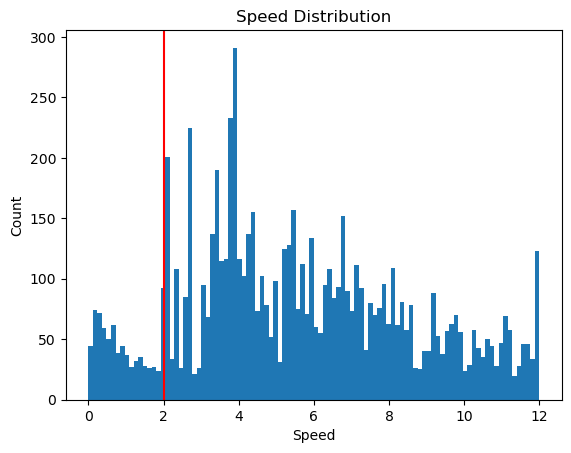

In [17]:
plot_hist(speed, bins=100, xlabel='Speed', ylabel='Count', title='Speed Distribution',)
add_vlines(PLACE['min_speed'], color='red')

In [18]:
# Compute the range of position data
area_range = compute_pos_ranges(positions)
area_range = [area_range[0],32]

In [19]:
# Collect together boundary ranges
print('Boundary range: ', area_range)

Boundary range:  [-33.9997, 32]


In [20]:
# Get trial information - start & end times
n_trials = len(nwbfile.trials)
trial_starts = nwbfile.trials.start_time[:]
trial_stops = nwbfile.trials.stop_time[:]

In [21]:
# Drop manual trials 
manual_indx = np.where(nwbfile.trials['drive_type'][:] == 'manual')[0]
manual_start = trial_starts[manual_indx]
manual_end = trial_stops[manual_indx]


move_starts = np.delete(trial_starts, manual_indx, axis=0)
move_stops= np.delete(trial_stops, manual_indx, axis=0)

In [22]:
# Compute bin edges
x_edges = compute_bin_edges(positions, BINS['place'])

# Compute Occupancy 

In [23]:
OCCUPANCY

{'minimum': 0.1, 'set_nan': True, 'min_speed': 2, 'max_time': 0.25}

In [24]:
# Compute occupancy values
occ = compute_occupancy(positions, ptimes, BINS['place'], area_range, speed,**OCCUPANCY)

/Users/weijiazhang/anaconda3/lib/python3.11/site-packages/spiketools/utils/checks.py:288: UserWarning: The data values extend beyond the given bin definition.
  warnings.warn(msg)


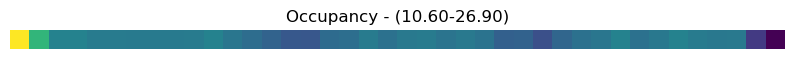

In [25]:
# Plot the occupancy
plot_heatmap(occ, title= create_heatmap_title('Occupancy', occ), figsize=(10, 6))

## Compute Trial Occupancy 

In [26]:
trial_occupancy = compute_trial_occupancy(positions, ptimes, BINS['place'],move_starts, move_stops,
                                               area_range,speed, **OCCUPANCY_TRIAL)

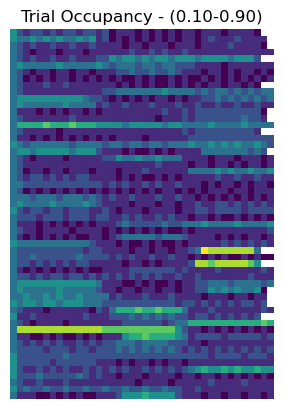

In [27]:
# Plot the occupancy
plot_heatmap(trial_occupancy, title= create_heatmap_title('Trial Occupancy', trial_occupancy))

## Post-hoc Check 

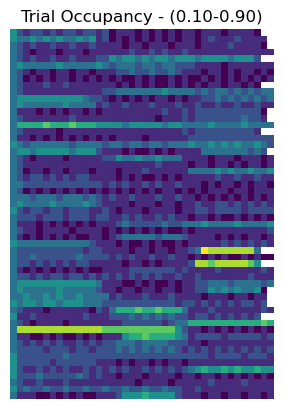

In [28]:
t_occupancy = np.nan_to_num(trial_occupancy, nan=0.0)
occ = np.sum(t_occupancy, axis=0)
trial_occupancy[:, occ < OCCUPANCY['minimum']] = np.nan
plot_heatmap(trial_occupancy, title= create_heatmap_title('Trial Occupancy', trial_occupancy))

# Spiking across location 

In [29]:
# Get spikes for unit of interest
spikes = nwbfile.units.get_unit_spike_times(uid)

In [30]:
# Get the positions for all spikes
#spikes = threshold_spikes_by_values(spikes_or, ptimes, speed, min_speed)
spike_positions,indx = get_values_by_times(ptimes, positions, spikes,time_threshold =PLACE['time_threshold'])
spike_t = ptimes[indx]

In [31]:
spike_positions.shape

(630,)

## Plots 

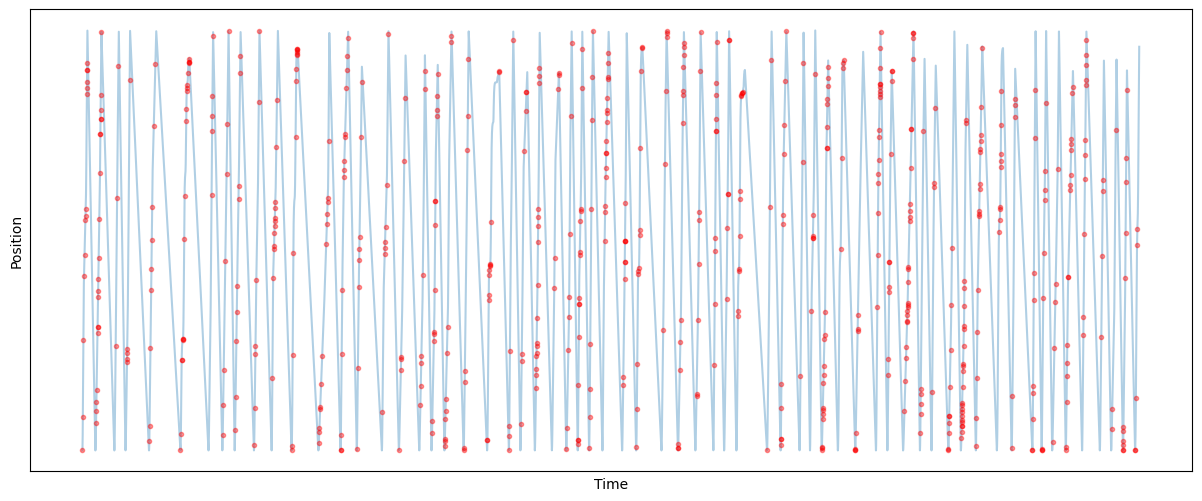

In [32]:
# Plot spikes across all y-positions
plot_position_by_time(ptimes, positions, spike_t, spike_positions, figsize=(15, 6))

# Unit Analysis: binned 

In [33]:
trial_place_bins = compute_trial_place_bins(spikes, positions, ptimes, BINS['place'],
                                    move_starts, move_stops, area_range,
                                    speed,**PLACE, trial_occupancy = trial_occupancy,flatten=True)

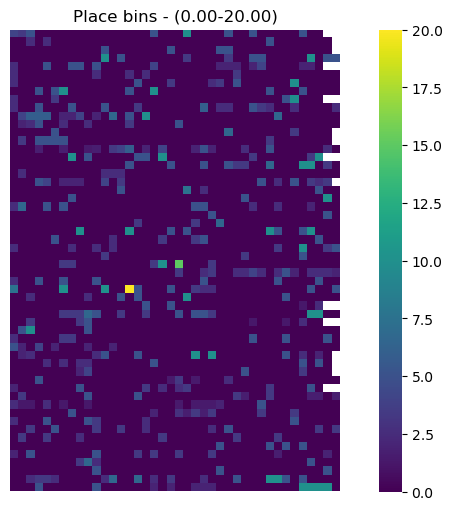

In [34]:
plot_heatmap(trial_place_bins, cbar=True,title= create_heatmap_title('Place bins', trial_place_bins), figsize=(10, 6))

## Removing the spatial bin with the highest firing rate on each trial 

In [35]:
HF_indx = np.argmax(trial_place_bins, axis=1)
for i, index in enumerate(HF_indx):
    trial_place_bins[i, index] = np.nan

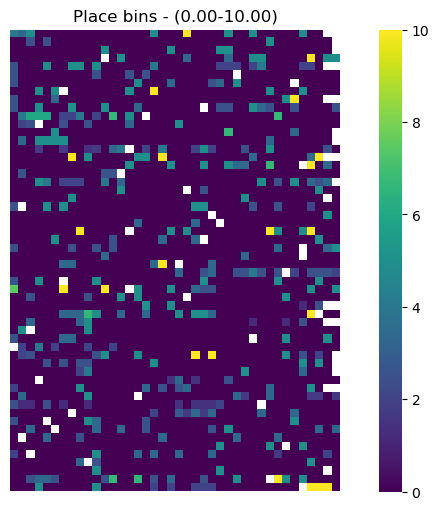

In [36]:
plot_heatmap(trial_place_bins, cbar=True,title= create_heatmap_title('Place bins', trial_place_bins), figsize=(10, 6))

## Z_score 

In [37]:
z_scores = zscore(trial_place_bins, axis=None)
outlier_threshold = 3.29
trial_place_bins[z_scores > outlier_threshold] = np.nan


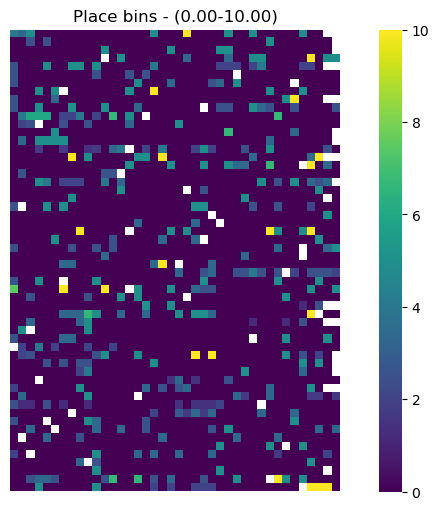

In [38]:
plot_heatmap(trial_place_bins, cbar=True,title= create_heatmap_title('Place bins', trial_place_bins), figsize=(10, 6))

In [59]:
s_bins = np.linspace(area_range[0], area_range[1], BINS['place']+1)

t_place_bins  = np.nan_to_num(trial_place_bins , nan=0.0)
place_bins = np.mean(t_place_bins, axis=0)
place_bins_std = np.std(t_place_bins, axis=0)
n_trials= t_place_bins.shape[0]
place_sem = place_bins_std / np.sqrt(n_trials)

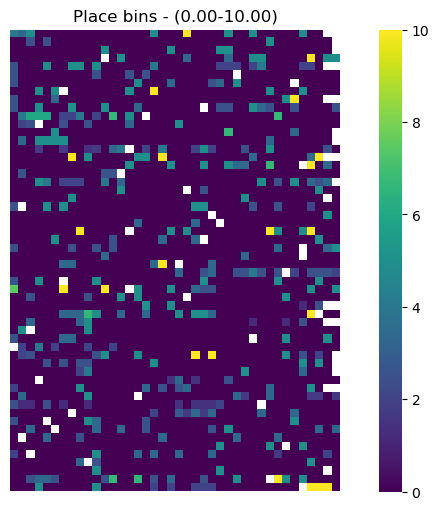

In [60]:
plot_heatmap(trial_place_bins, cbar=True,title= create_heatmap_title('Place bins', trial_place_bins), figsize=(10, 6))

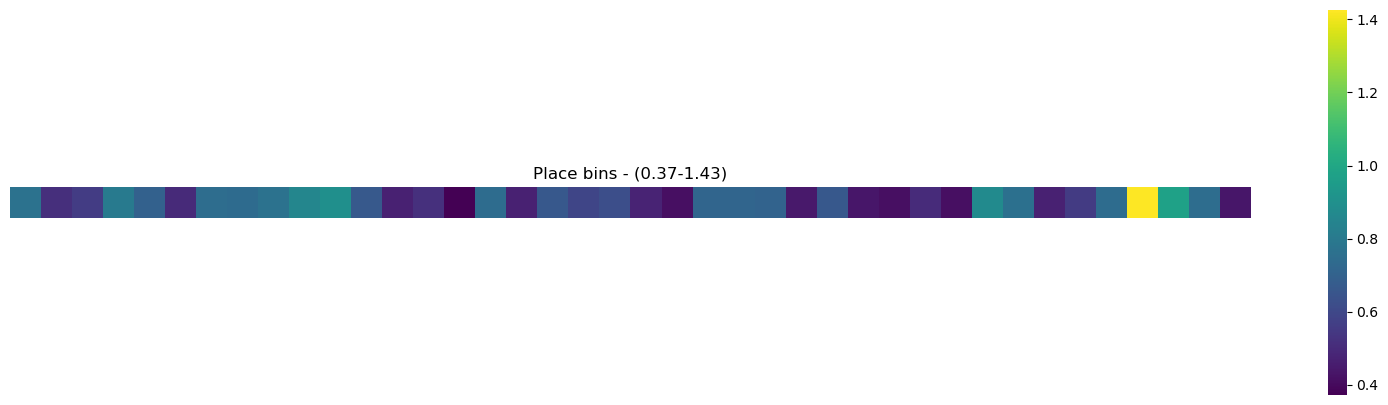

In [61]:
plot_heatmap(place_bins, cbar=True,title= create_heatmap_title('Place bins', place_bins), figsize=(20, 5))

In [62]:
# Check the min/max firing rate across bins
print('Min / Max firing rate : {:1.2f}, {:1.2f}'.format(*compute_range(place_bins)))
print('Average firing Rate   : {:1.2f}'.format(np.nanmedian(place_bins)))

Min / Max firing rate : 0.37, 1.43
Average firing Rate   : 0.66


## Unit Analysis: Spike Positions

In [63]:
# Get spikes per trial
trial_spikes = epoch_spikes_by_range(spikes, move_starts, move_stops)

In [64]:
# Get spike trial positions 
spike_pos = []
for t_spikes in trial_spikes:
    spike_p,indx = get_values_by_times(ptimes, positions, t_spikes,PLACE['time_threshold'])
    spike_pos.append(spike_p)

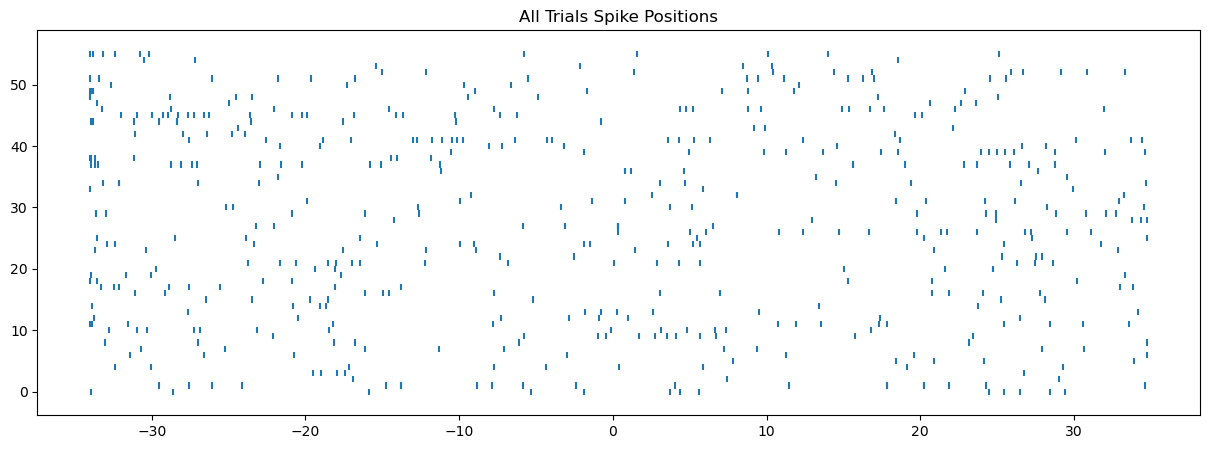

In [65]:
plot_rasters(spike_pos, vline=None, figsize=(15, 5), show_axis=True, title='All Trials Spike Positions')

# Statistical Analyses 

In [66]:
# Create shuffled surrogates
shuffles = shuffle_spikes(spikes, **SURROGATES)

In [67]:
METHODS

{'PLACE': ['ANOVA', 'INFO']}

In [68]:
SURROGATES

{'approach': 'CIRCULAR', 'n_shuffles': 100}

In [69]:
PLACE_MODELS

{'MODEL': 'fr ~ C(bin)', 'FEATURE': 'C(bin)', 'COLUMNS': ['bin', 'fr']}

## Spatial Information 
- Analyze the spatial information - the mutual information between space and firing rate

In [71]:
# Compute mutual information of spiking and location
results['place_info'] = compute_spatial_information(place_bins, occ, normalize=False)
print(results['place_info'])

0.06207699511877174


## ANOVA Analysis 
- ANOVA, then surrogate test for the F-statistic

Possible formulas:

- fr ~ C(x) + C(y) + x:y
- fr ~ C(bin)

Set up ANOVA:

- bin data per trial (same binning as before)
- get a firing rate per bin, per trial
- this should exclude stationary segments
- create a dataframe with fr and bin features

In [72]:
# Check the model definition that is being used
PLACE_MODELS

{'MODEL': 'fr ~ C(bin)', 'FEATURE': 'C(bin)', 'COLUMNS': ['bin', 'fr']}

In [73]:
# Create the dataframe
results['place_anova'] = fit_anova_place(create_df_place(trial_place_bins))

In [74]:
# Check the computed place F-value
print('The ANOVA place F-value is {:4.2f}'.format(results['place_anova'] ))

The ANOVA place F-value is 0.79


# SURROGATES

In [75]:
surr_analyses = create_methods_list(METHODS)
surrs = {analysis : \
                    np.zeros(SURROGATES['n_shuffles']) for analysis in surr_analyses}
surrs

{'place_anova': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'place_info': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])}

In [76]:
for ind, shuffle in enumerate(shuffles):
    surr_trial_place_bins = compute_trial_place_bins(shuffle, positions, ptimes, BINS['place'],
                                             move_starts,move_stops, area_range,
                                             speed, **PLACE, trial_occupancy = trial_occupancy,flatten=True)
    
    ## Drop Highest Index 
    HF_indx = np.argmax(surr_trial_place_bins, axis=1)
    for i, index in enumerate(HF_indx):
        surr_trial_place_bins[i, index] = np.nan

    z_scores = zscore(surr_trial_place_bins, axis=None)
    outlier_threshold = 3.29
    surr_trial_place_bins[z_scores > outlier_threshold] = 0
    
    surr_t_place_bins  = np.nan_to_num(surr_trial_place_bins , nan=0.0)
    surr_place_bins= np.mean(surr_t_place_bins,axis = 0)
   
    
    surrs['place_info'][ind] = compute_spatial_information(surr_place_bins, occ, normalize=False)

    surrs['place_anova'][ind] = fit_anova_place(create_df_place(surr_trial_place_bins))
   

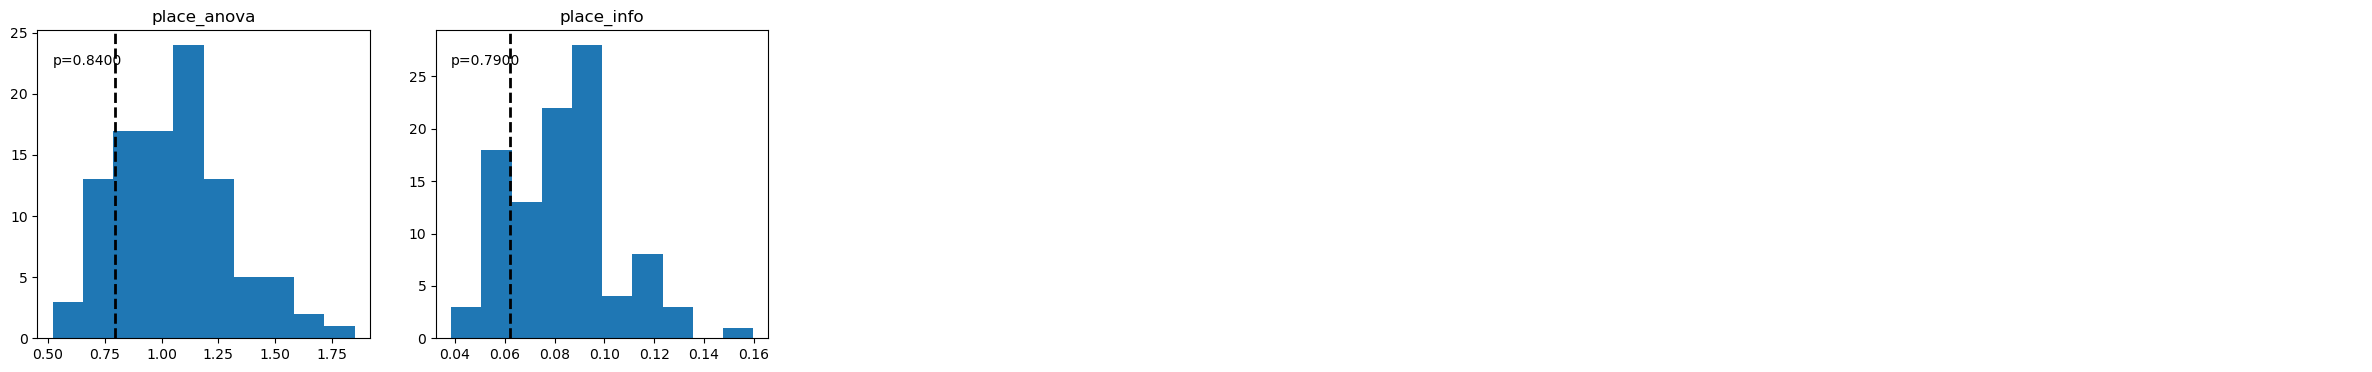

In [77]:
axes = make_axes(2, 6, figsize=(30, 4))
i = 0
for analysis in surr_analyses:
    results[analysis + '_surr_p_val'], results[analysis + '_surr_z_score'] = \
                        compute_surrogate_stats(results[analysis], surrs[analysis],title = analysis,plot = True, ax=axes[i])
    i = i+1

# Reports 

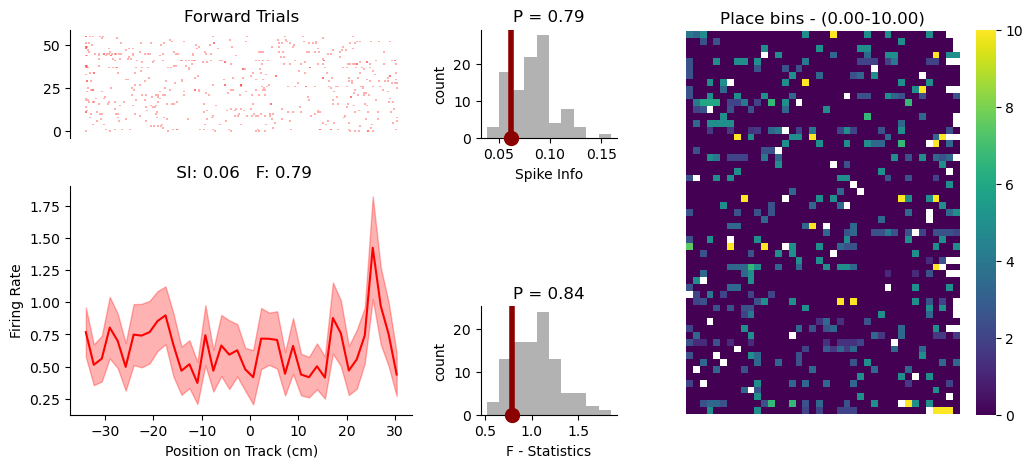

In [78]:
grid = make_grid(3, 6, wspace=.5, hspace=.5, figsize=(15, 5),
                     height_ratios=[1.2,.8, 1.2])

plt.rcParams.update({'font.size': 10})
SI = results['place_info']
F = results['place_anova']
ax = get_grid_subplot(grid, 0, slice(0,2))
plot_rasters(spike_pos,ax = ax, vline=None, figsize=(10, 5),color = 'red',alpha =.3, show_axis=True, title='Forward Trials')
ax.set_xticklabels([])
ax.set_xlabel('')
ax.get_xaxis().set_visible(False)
drop_spines(['top','right','bottom'],ax = ax)

ax = get_grid_subplot(grid, slice(1,3), slice(0,2))
ax.plot(s_bins[:-1], place_bins, color = 'red', label='Mean Value')
ax.fill_between(s_bins[:-1], place_bins - place_sem, place_bins+ place_sem, color = 'red', alpha=0.3)
ax.set_xlabel('Position on Track (cm)')
ax.set_ylabel('Firing Rate')
ax.set_title(f' SI: {np.round(SI,2)}   F: {np.round(F,2)}')

drop_spines(['top','right'],ax = ax)

ax = get_grid_subplot(grid, 0, 2)
P = results['place_info_surr_p_val']
plot_surrogates(surrs['place_info'], data_value=SI, p_value=None, title=f'P = {P}',
                                     title_color=color_pvalue(P),ax = ax,alpha = .6,color = 'grey')
add_vlines(SI , ax, color='darkred', linestyle='solid', linewidth=4)
ax.plot(SI , 0, 'o', zorder=10, clip_on=False, color='darkred', markersize=10)
ax.set_xlabel('Spike Info')
ax.set_ylabel('count')
drop_spines(['top', 'right'],ax)

ax = get_grid_subplot(grid, 2, 2)
P = results['place_anova_surr_p_val']
plot_surrogates(surrs['place_anova'], data_value=F, p_value=None ,title=f'P = {P}',
                                     title_color=color_pvalue(P),ax = ax,alpha = .6,color = 'grey')
add_vlines(F , ax, color='darkred', linestyle='solid', linewidth=4)
ax.plot(F , 0, 'o', zorder=10, clip_on=False, color='darkred', markersize=10)
ax.set_xlabel('F - Statistics')
ax.set_ylabel('count')
drop_spines(['top', 'right'],ax)

ax = get_grid_subplot(grid, slice(0,3), slice(3,5))
plot_heatmap(trial_place_bins, cbar=True,title= create_heatmap_title('Place bins', trial_place_bins), ax=ax)

# ALL UNITS

In [58]:
METHOD = 'anova'  # 'info', 'anova'

In [79]:
# # Run analysis to compute spatial information measures across all cells
# for uid, ax in zip(range(n_units), make_axes(n_units)):

#     spikes_or = nwbfile.units.get_unit_spike_times(uid)
#     spikes = threshold_spikes_by_values(spikes_or, ptimes, speed, min_speed)
#     place_bins = compute_place_bins(shuffle, positions, ptimes, bins, area_range,
#                                     speed, min_speed=min_speed,
#                                     time_threshold=time_threshold, occupancy=occ)
    
#     if METHOD == 'info':
#         data_value = compute_spatial_information(place_bins, occ, normalize=False)


#     if METHOD == 'anova':
#         # Compute the spatially binned spike activity per trial
#         trial_fr = compute_trial_place_bins(spikes, positions, ptimes, bins,
#                                     move_starts, move_stops, area_range,
#                                     speed, min_speed=min_speed, 
#                                     time_threshold=time_threshold,trial_occupancy=trial_occupancy, flatten=True)
#         data_value = fit_anova_place(create_df_place(trial_fr))

#     surrs = np.zeros(n_surrogates)
#     shuffles = shuffle_spikes(spikes_or, shuffle_approach, n_surrogates)
#     for ind, shuffle in enumerate(shuffles):
#         #shuffle = threshold_spikes_by_values(shuffle, ptimes, speed, min_speed)
#         if METHOD == 'info':
#             shuffle = threshold_spikes_by_values(spikes_or, ptimes, speed, min_speed)
#             surr_place_bins = compute_place_bins(shuffle, positions, ptimes, bins, area_range,
#                                                  speed, min_speed=min_speed, occupancy=occ)
#             surrs[ind] = compute_spatial_information(surr_place_bins, occ, normalize=False)

#         if METHOD == 'anova':
#             surr_trial_fr = compute_trial_place_bins(shuffle, positions, ptimes, bins,
#                                                      move_starts,move_stops, area_range,speed,min_speed=min_speed, 
#                                     time_threshold=time_threshold,trial_occupancy=trial_occupancy, flatten=True)
#             surrs[ind] = fit_anova_place(create_df_place(surr_trial_fr))
            
#     p_val, z_score = compute_surrogate_stats(data_value, surrs)
    
#     print(p_val)
#     #plot_heatmap(place_bins,ax=ax)
#     s_bins = np.linspace(area_range[0], area_range[1], bins+1)
#     place_bins = np.mean(trial_fr, axis=0)
#     place_std = np.std(trial_fr, axis=0)
#     place_n= trial_fr.shape[0]
#     place_sem = place_std  / np.sqrt(place_n)
    
#     ax = ax
#     ax.plot(s_bins[:-1], place_bins, linewidth = '2',color = 'red')
#     ax.fill_between(s_bins[:-1],place_bins - place_sem, place_bins + place_sem, color = 'red', alpha=0.3)
#     ax.set_xlabel('Position on Track')
#     ax.set_ylabel('Firing Rate')
#     ax.spines['top'].set_visible(False)
#     ax.spines['right'].set_visible(False)
#     ax.set_xticklabels([])
#     ax.set_xlabel('')
#     ax.set_title(create_heatmap_title(f'U{uid}-FR: ', place_bins, stat=z_score, p_val=p_val), color=color_pvalue(p_val, alpha=0.05))
   